In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Model 
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import random

In [4]:
df = pd.read_excel('DFI -Ticketing.xlsx', sheet_name=None)

df = pd.DataFrame(df['Export - Tickets'])

In [5]:
df.head()

ID           Structure  ...     Category Sub-Category
0  55019  NUTRITION ET SANTE  ...  Supervision          NaN
1  55020  POCLAIN HYDRAULICS  ...          NaN          NaN
2  55021             RATPDEV  ...          NaN          NaN
3  55023                D-FI  ...          NaN          NaN
4  55024  POCLAIN HYDRAULICS  ...          NaN          NaN

[5 rows x 29 columns]

In [6]:
df['Incident-Subject'][0]

" Bonsoir  \xa0  Notre outil de supervision a remonté l'alerte suivante:  \xa0  Client:  Serveur: FRDAPLANIF1  Adresse IP: 170.237.25.77  Service: Service: _SMAOpConMinosService_\xa0  Note: Serveur Windows  \xa0  Retour du check: SMAOpConMinosService: Stopped  \xa0  \xa0  Cordialement, Adil  "

In [7]:
df = df.dropna(subset=['Incident-Subject','Team'])
df.shape

(89041, 29)

In [8]:
len(df.Team.unique())
df.Team.unique()

array(['PILOTAGE', 'SUPPORT BT NETAPP', 'SAUVEGARDE', 'AS400', 'RESEAUX',
       'WINDOWS', 'LINUX', 'COBICOM', 'SDM', 'BT TOOLS', 'SUPPORT BT',
       'DBA', 'OPENINFO', 'PROJET RC', 'SUPPORT QUICK-EDD',
       'PROD APPLICATIVE', 'DIR-PROD', 'SAP', 'INFOGERANCE GLOBALE',
       'IT INTERNE', 'SUPPORT PLA', 'SG-IS-SUPPORT', 'OZITEM',
       'DATACENTER', 'TOYS-INNERWORK', 'AIX'], dtype=object)

In [9]:
x= [len(df.loc[df['Team']==i])  for i in df.Team.unique()]
x

[53719,
 77,
 3144,
 6437,
 2849,
 8815,
 2322,
 1461,
 1785,
 1325,
 1,
 861,
 45,
 53,
 5,
 1018,
 137,
 216,
 1,
 3517,
 1195,
 32,
 1,
 8,
 8,
 9]

In [10]:
text_data= (df['Incident-Subject']).values
text_data = text_data.reshape(-1,1)
lables = df['Team']
lables = pd.get_dummies(lables)
lables_columns=lables.columns
lables = lables.values

In [11]:

oversample = RandomOverSampler(sampling_strategy='minority')
text_data, lables = oversample.fit_resample(text_data, lables)
text_data.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(142759, 1)

In [12]:
data=[]
for i in  range(0,text_data.shape[0]):
  data.append([text_data[i],lables[i]])

text_data=[]
lables=[]
random.shuffle(data)

for i in  range(0,len(data)):
  text_data.append(data[i][0])
  lables.append(data[i][1])

text_data = np.array(text_data)
lables = np.array(lables)

In [13]:
vocab_size = 10000
embedding_dim = 32
max_length = 1000
trunc_type = 'post'
oov_tok = 'nulll'
training_percentage = 0.7
validation_percentage = 0.2
train_size = int(training_percentage*text_data.shape[0])
validation_size = int(validation_percentage*text_data.shape[0])

In [14]:
elements_greater = [len(i) for i in text_data if len(i)>5000]
len(elements_greater)

0

In [15]:

train_text_data = text_data[:train_size]
validation_text_data= text_data[train_size:train_size+validation_size]
test_text_data= text_data[train_size+validation_size:]

print(len(train_text_data))
print(len(validation_text_data))
print(len(test_text_data))


99931
28551
14277


In [16]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text_data.ravel())
word_index = tokenizer.word_index

train_text_data = tokenizer.texts_to_sequences(train_text_data.ravel())
train_text_data = pad_sequences(train_text_data,maxlen=max_length)


train_text_data.shape

(99931, 1000)

In [17]:

validation_text_data =tokenizer.texts_to_sequences(validation_text_data.ravel())
validation_text_data =pad_sequences(validation_text_data,maxlen=max_length)

validation_text_data.shape

(28551, 1000)

In [18]:

test_text_data =tokenizer.texts_to_sequences(test_text_data.ravel())
test_text_data =pad_sequences(test_text_data,maxlen=max_length)

test_text_data.shape



(14277, 1000)

In [19]:

y_train = lables[:train_size]
validation_lables =  lables[train_size:validation_size+train_size]
test_lables =  lables[validation_size+train_size:]


In [20]:
def Model():
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)


    model= tf.keras.models.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",activation="relu"),
        #tf.keras.layers.MaxPooling1D(pool_size=2),

        #tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu"),
        #tf.keras.layers.MaxPooling1D(pool_size=2),

       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                 tf.keras.layers.Flatten(),

         tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(32, activation='relu'),
         tf.keras.layers.Dense(26, activation='softmax'),

    ])

    model.compile(loss='categorical_crossentropy',  optimizer='adam',metrics = 'accuracy')
    
    return model

In [21]:
checkpoint_filepath = 'best_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True)

In [22]:
model= Model()
history = model.fit(train_text_data,y_train,epochs=5,verbose=1,callbacks=[model_checkpoint_callback],validation_data=(validation_text_data,validation_lables),batch_size=32,shuffle=True)


Epoch 1/5
3123/3123 [==============================] - 458s 143ms/step - loss: 0.9136 - accuracy: 0.7522 - val_loss: 0.6023 - val_accuracy: 0.8221

Epoch 00001: val_loss improved from inf to 0.60229, saving model to best_model
Epoch 2/5
3123/3123 [==============================] - 434s 139ms/step - loss: 0.5610 - accuracy: 0.8321 - val_loss: 0.5290 - val_accuracy: 0.8394

Epoch 00002: val_loss improved from 0.60229 to 0.52896, saving model to best_model
Epoch 3/5
3123/3123 [==============================] - 421s 135ms/step - loss: 0.4569 - accuracy: 0.8637 - val_loss: 0.4769 - val_accuracy: 0.8590

Epoch 00003: val_loss improved from 0.52896 to 0.47693, saving model to best_model
Epoch 4/5
3123/3123 [==============================] - 423s 136ms/step - loss: 0.3952 - accuracy: 0.8812 - val_loss: 0.4571 - val_accuracy: 0.8653

Epoch 00004: val_loss improved from 0.47693 to 0.45709, saving model to best_model
Epoch 5/5
3123/3123 [==============================] - 437s 140ms/step - loss: 0

In [23]:
results = model.evaluate(test_text_data, test_lables)

447/447 [==============================] - 28s 63ms/step - loss: 0.4454 - accuracy: 0.8712


In [24]:
model.load_weights(checkpoint_filepath)


In [25]:
results = model.evaluate(test_text_data, test_lables)

447/447 [==============================] - 28s 64ms/step - loss: 0.4454 - accuracy: 0.8712


In [26]:
model.save('my_model.h5')


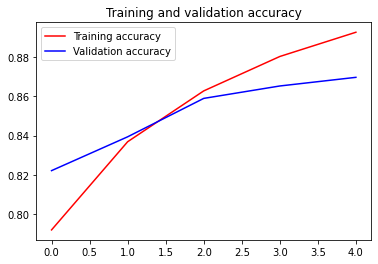

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

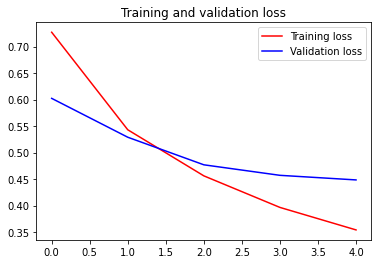

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()